In [1]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
import numpy as np
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda,floatX=float32"
import theano

from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_mldata

Using cuDNN version 7005 on context None
Mapped name None to device cuda: Quadro K2100M (0000:01:00.0)
Using Theano backend.


# Softmax sklearn

In [115]:
mnist = fetch_mldata('MNIST original')
X = mnist.data
y = mnist.target

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2)
# y_train = y_train.astype(int)
# y_test = y_test.astype(int)

In [78]:
softmax = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
softmax.fit(X_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [79]:
y_pred = softmax.predict(X_test)

In [80]:
print('Accuracy score: {:.4}'.format(100*accuracy_score(y_test, y_pred)))

Accuracy score: 92.09


In [116]:
# one-vs-rest logistic regression
softmax = LogisticRegression(C=1e5, solver='lbfgs', multi_class='ovr')
softmax.fit(X_train, y_train)
y_pred = softmax.predict(X_test)
print('Accuracy score: {:.4}'.format(100*accuracy_score(y_test, y_pred)))

Accuracy score: 91.14


# Softmax

In [99]:
def softmax(Z):
    """
    Compute softmax values for each sets of scores in V.
    each column of V is a set of scores.    
    Z: a numpy array of shape (N, C)
    return a numpy array of shape (N, C)
    """
    e_Z = np.exp(Z)
    return e_Z/np.sum(e_Z, axis=1, keepdims=True)

def softmax_stable(Z):
    """
    Compute softmax values for each sets of scores in Z.
    each row of Z is a set of scores.    
    """
    Z-=np.max(Z, axis=1, keepdims=True)
    e_Z = np.exp(Z)
    return e_Z/np.sum(e_Z, axis=1, keepdims=True)

def softmax_loss(X, y, W):
    """
    W: 2d numpy array of shape (d, C), 
        each column correspoding to one output node
    X: 2d numpy array of shape (N, d), each row is one data point
    y: 1d numpy array -- label of each row of X 
    """
    A=softmax_stable(np.dot(X, W))
    enum=range(len(A))
    return -np.mean(np.log(A[enum, y]))

def softmax_grad(X, y, W):
    """
    W: 2d numpy array of shape (d, C), 
        each column correspoding to one output node
    X: 2d numpy array of shape (N, d), each row is one data point
    y: 1d numpy array -- label of each row of X 
    """
    A=softmax_stable(np.dot(X, W))
    enum=range(len(A))
    A[enum, y]-=1
    return np.dot(X.T, A)/len(X)

def softmax_fit(X, y, W, lr=0.01, nepoches=100, batch_size=10):
    W_old = W.copy()
    # store history of loss in loss_hist
    loss_hist=[softmax_loss(X, y, W)]
    ep=0
    n_batches=int(len(X)/batch_size)
    while ep < nepoches:
        mix_idx = np.random.permutation(X.shape[0])
        for i in range(n_batches):
            batch=mix_idx[batch_size*i:batch_size*(i+1)]
            X_batch, y_batch = X[batch], y[batch]
            W-=lr*(softmax_grad(X_batch, y_batch, W))
        loss_hist.append(softmax_loss(X, y, W))
        if np.linalg.norm(W)/W.size < 1e-5:
            break
        ep+=1
        W_old=W.copy()
    return W, loss_hist

def pred(W, X):
    """
    predict output of each columns of X
    Class of each x_i is determined by location of max probability
    Note that class are indexed by [0, 1, 2, ...., C-1]
    """
    return np.argmax(softmax_stable(np.dot(X, W)), axis=1)

In [100]:
d = 100
C = 3 
N = 3000
X = np.random.randn(N, d)
y = np.random.randint(0, C, N)
W = np.random.randn(d, C)
W, loss_hist = softmax_fit(X, y, W, batch_size = 100, lr= 0.05)

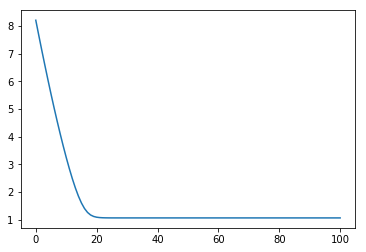

In [101]:
plt.plot(loss_hist)
plt.show()

## Apply Softmax to MNist

In [110]:
W_shape = (X_train.shape[1], len(np.unique(y_train)))
W = np.random.normal(0, np.sqrt(2./np.sum(W_shape)), W_shape)
W, loss_hist = softmax_fit(X_train, y_train, W, batch_size = 100, lr= 0.05)

In [114]:
print('Accuracy score: {:.4}'.format(100*accuracy_score(y_test, pred(W, X_test))))

Accuracy score: 85.44
